This script is to convert the raw .bag file from the mobile base. The mobile base data has two topics: ar_tags and encoders. 

ar_tags has a message containiing xyz position and a quaternion for each visible ar tag. 

Encoders has castor and segway encoder counts, which should give us odometry through the kinematic model of the base. 

In [2]:
from bagpy import bagreader
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation

In [3]:
b = bagreader('./slam_data_1.bag')
b.topic_table

[INFO]  Data folder ./slam_data_1 already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/mobile_base_0/ar_tags,base_msgs/arTagArray,1684,3.247758
1,/mobile_base_0/encoders,base_msgs/baseEncoders,64152,100.054962


# Measurement Data

In [4]:
tag_csv = b.message_by_topic('/mobile_base_0/ar_tags')
tag_data = pd.read_csv(tag_csv)

tag_data['Time'] = tag_data['Time'] - tag_data['Time'][0]
tag_data


,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,tags
0,0.000000,1,1669159522,187745809,NaN,[id: 37\npose: \n position: \n x: -10.4718...
1,0.297291,2,1669159522,484997987,NaN,[id: 37\npose: \n position: \n x: -10.4718...
2,0.606688,3,1669159522,794341802,NaN,[id: 37\npose: \n position: \n x: -10.4718...
3,0.911516,4,1669159523,99001169,NaN,[id: 37\npose: \n position: \n x: -10.4718...
4,1.247960,5,1669159523,435541391,NaN,[id: 37\npose: \n position: \n x: -10.4718...
...,...,...,...,...,...,...
1679,640.170521,1680,1669160162,358277320,NaN,[id: 17\npose: \n position: \n x: -3.53977...
1680,640.473278,1681,1669160162,661100149,NaN,[id: 17\npose: \n position: \n x: -3.53977...
1681,640.790020,1682,1669160162,977586507,NaN,[id: 17\npose: \n position: \n x: -3.53977...
1682,641.105750,1683,1669160163,293509483,NaN,[id: 17\npose: \n position: \n x: -3.53977...


I guess tags get decoded as strings. Darn.

In [5]:
def get_tag_list(tag_string:str):
    return tag_string.replace('\n',' ').replace(' ', '').replace('[','').replace(']','').split(',')


In [6]:
def get_xz(tag_string:str):
    x_start = tag_string.find('x:')+2
    y_start = tag_string.find('y:')+2
    z_start = tag_string.find('z:')+2
    orientation_start = tag_string.find('orientation')

    x = float(tag_string[x_start:y_start-2])
    z = float(tag_string[z_start:orientation_start])  * 20.4/100.0 #magical z scaling number with Shaden
    return [x,z]

In [7]:
def get_range(tag_string:str):
    x,z = get_xz(tag_string)
    return np.sqrt(x**2 + z**2)

In [8]:
def get_bearing(tag_string:str):
    x,z = get_xz(tag_string)
    return np.arctan2(x,z)


In [9]:
def extract_measurement_data(tag_list:list, degrees:bool = False):
    data = []
    valid_id = list(range(1,39))
    for tag in tag_list:
        #find id tag
        start = 3 #after "id:"
        end = tag.find('pose')
        tag_id = int(tag[start:end])
        # print(tag_id)
        if tag_id in valid_id:
            rang = get_range(tag)
            bearing = get_bearing(tag)
            data.append([tag_id, rang, bearing])

    return data


In [10]:
data = []
for i in range(len(tag_data['tags'])):
# for i in range(5):
    time = float(tag_data['Time'][i])
    tag_list = get_tag_list(tag_data['tags'][i])
    # print(tag_list)
    measurement = extract_measurement_data(tag_list, degrees=True)
    # print(measurement)
    data.append([time]+measurement)

In [11]:
with open('measurement_data.txt', 'w') as f:
    for data_point in data:
        f.write(str(data_point))
        f.write('\n')

# Odometry Data

In [12]:
import sympy as sym

In [13]:
rx,rz,w,vx,vz = sym.symbols('r_x, r_z, omega, v_x, v_y',real=True)
vO = sym.Matrix([vx, 0, vz])
wO = sym.Matrix([0,w,0])

r0 = sym.Matrix([-rx,0,-rz])
r1 = sym.Matrix([rx,0,-rz])
r2 = sym.Matrix([-rx,0,rz])
r3 = sym.Matrix([rx,0,rz])


In [14]:
r0

Matrix([
[-r_x],
[   0],
[-r_z]])

In [15]:
v_wheel0 = vO + wO.cross(r0)
v_wheel1 = vO + wO.cross(r1)
v_wheel2 = vO + wO.cross(r2)
v_wheel3 = vO + wO.cross(r3)

In [16]:
v_wheel0

Matrix([
[-omega*r_z + v_x],
[               0],
[ omega*r_x + v_y]])

In [17]:
v_wheel1

Matrix([
[-omega*r_z + v_x],
[               0],
[-omega*r_x + v_y]])

In [18]:
v_wheel2

Matrix([
[omega*r_z + v_x],
[              0],
[omega*r_x + v_y]])

In [19]:
v_wheel3

Matrix([
[ omega*r_z + v_x],
[               0],
[-omega*r_x + v_y]])

Putting this into matrix form

In [20]:
M = sym.Matrix(
    [
        [1,0,-rz],
        [0,1,rx],
        [1,0,-rz],
        [0,1,-rx],
        [1,0,rz],
        [0,1,rx],
        [1,0,rz],
        [0,1,-rx]
    ]
)
Minv = M.pinv()
Minv

Matrix([
[                       1/4,                         0,                        1/4,                          0,                       1/4,                         0,                       1/4,                          0],
[                         0,                       1/4,                          0,                        1/4,                         0,                       1/4,                         0,                        1/4],
[-r_z/(4*r_x**2 + 4*r_z**2), r_x/(4*r_x**2 + 4*r_z**2), -r_z/(4*r_x**2 + 4*r_z**2), -r_x/(4*r_x**2 + 4*r_z**2), r_z/(4*r_x**2 + 4*r_z**2), r_x/(4*r_x**2 + 4*r_z**2), r_z/(4*r_x**2 + 4*r_z**2), -r_x/(4*r_x**2 + 4*r_z**2)]])

In [21]:
calc_Minv = sym.utilities.lambdify([rx, rz], Minv)

To get robot velocities vx,vy,and omega:

$$
\begin{equation}
\left[\begin{array}{l}
v_x \\
v_y \\
\omega
\end{array}\right]=\mathbf{M}^{\dagger}\left[\begin{array}{l}
v_{0 x} \\
v_{0 y} \\
v_{1 x} \\
v_{1 y} \\
v_{2 x} \\
v_{2 y} \\
v_{3 x} \\
v_{3 y}
\end{array}\right]
\end{equation}
$$

Now I need to convert encoder ticks to wheel velocities. Equation to get the ith wheel velocity is 

$$ v_i = \frac{D}{2} \omega_i \left[\begin{array}{l}
sin(\theta) \\
0 \\
cos(\theta)
\end{array}\right]$$

$\omega_i$ comes from the segway encoders. $D$ is the diameter of the wheels. $\theta$ comes from the caster encoder data (which is recorded already as angles).


In [22]:
encoder_csv = b.message_by_topic('/mobile_base_0/encoders')
encoder_data = pd.read_csv(encoder_csv)
encoder_data['Time'] = encoder_data['Time'] - encoder_data['Time'][0]
encoder_data['segway.segway_0'] = encoder_data['segway.segway_0'] - encoder_data['segway.segway_0'][0]
encoder_data['segway.segway_1'] = encoder_data['segway.segway_1'] - encoder_data['segway.segway_1'][0]
encoder_data['segway.segway_2'] = encoder_data['segway.segway_2'] - encoder_data['segway.segway_2'][0]
encoder_data['segway.segway_3'] = encoder_data['segway.segway_3'] - encoder_data['segway.segway_3'][0]

encoder_data.head()

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,castor.castor_0,castor.castor_1,castor.castor_2,castor.castor_3,segway.segway_0,segway.segway_1,segway.segway_2,segway.segway_3
0,0.000000,1,1669159522,133120059,NaN,-0.000026,0.000026,0.0,0.0,0,0,0,0
1,0.010591,2,1669159522,143382787,NaN,-0.000026,0.000026,0.0,0.0,0,0,0,1
2,0.020314,3,1669159522,153208971,NaN,-0.000026,0.000026,0.0,0.0,0,0,0,1
3,0.030217,4,1669159522,163164377,NaN,-0.000026,0.000026,0.0,0.0,0,0,0,1
4,0.040277,5,1669159522,173169136,NaN,-0.000026,0.000026,0.0,0.0,0,0,0,1


In [31]:
segway_radPerTick = 4 * np.pi/180.
D = .255
M_inv = calc_Minv(.4, .56)

base_velocity_data = []
for i in range(len(encoder_data['Time']) - 1):
# for i in range(2):
    theta0 = encoder_data['castor.castor_0'][i]
    theta1 = encoder_data['castor.castor_1'][i]
    theta2 = encoder_data['castor.castor_2'][i]
    theta3 = encoder_data['castor.castor_3'][i]

    dt = encoder_data['Time'][i+1] - encoder_data['Time'][i]
    omega0 = segway_radPerTick * (encoder_data['segway.segway_0'][i+1] - encoder_data['segway.segway_0'][i])/dt 
    omega1 = segway_radPerTick * (encoder_data['segway.segway_1'][i+1] - encoder_data['segway.segway_1'][i])/dt 
    omega2 = segway_radPerTick * (encoder_data['segway.segway_2'][i+1] - encoder_data['segway.segway_2'][i])/dt 
    omega3 = segway_radPerTick * (encoder_data['segway.segway_3'][i+1] - encoder_data['segway.segway_3'][i])/dt 

    v0x = D*omega0*np.sin(theta0)/2
    v0z = D*omega0*np.cos(theta0)/2

    v1x = D*omega1*np.sin(theta1)/2
    v1z = D*omega1*np.cos(theta1)/2

    v2x = D*omega2*np.sin(theta2)/2
    v2z = D*omega2*np.cos(theta2)/2

    v3x = D*omega3*np.sin(theta3)/2
    v3z = D*omega3*np.cos(theta3)/2

    v_wheels = np.array([v0x,v0z,v1x,v1z,v2x,v2z,v3x,v3z])

    base_velocity = M_inv @ v_wheels
    v_base = np.sqrt(base_velocity[0]**2 + base_velocity[1]**2)

    #ignore lots of encoder ticks that don't change
    if v_base != 0 and base_velocity[-1] != 0:
        base_velocity_data.append([encoder_data['Time'][i]] + [v_base, base_velocity[-1]])


In [35]:
with open('odometry_data.txt', 'w') as f:
    for data_point in base_velocity_data:
        f.write(str(data_point))
        f.write('\n')

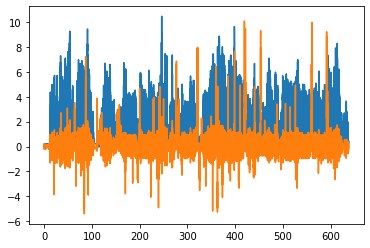

In [32]:
velocity = [base_velocity_data[i][1] for i in range(len(base_velocity_data))]
ang_velocity = [base_velocity_data[i][-1] for i in range(len(base_velocity_data))]
time = [base_velocity_data[i][0] for i in range(len(base_velocity_data))]
import matplotlib.pyplot as plt
plt.plot(time, velocity)
plt.plot(time, ang_velocity)

In [46]:
position_data = []

t0 = 0
x = 0
y = 0
theta = 0
position_data.append([t0,x,y,theta])
for i in range(len(base_velocity_data)-1):
    v = base_velocity_data[i][1]
    w = base_velocity_data[i][2]
    ratio = v/w
    dt = base_velocity_data[i+1][0]-base_velocity_data[i][0]
    x = x + -ratio*np.sin(theta) + ratio*np.sin(theta + w*dt)
    y = y + ratio*np.cos(theta) - ratio*np.cos(theta + w*dt)
    theta = theta+w*dt
    position_data.append([encoder_data['Time'][i]]+[x,y,theta])

In [47]:
np.vstack(position_data)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.05494469e-02, -4.69987498e-05,
        -8.91012375e-03],
       [ 1.05910301e-02,  6.58357512e-02,  7.51484445e-04,
         3.77935043e-02],
       ...,
       [ 1.66700312e+02,  9.41213365e+01,  1.36620150e+02,
        -1.09215380e-01],
       [ 1.66710005e+02,  9.41663023e+01,  1.36614346e+02,
        -1.47510610e-01],
       [ 1.66719977e+02,  9.41770070e+01,  1.36612806e+02,
        -1.38376261e-01]])

In [38]:
np.save('velocity_odometry_data', np.vstack(position_data))

with open('velocity_odometry_data.txt', 'w') as f:
    for data_point in position_data:
        f.write(str(data_point))
        f.write('\n')

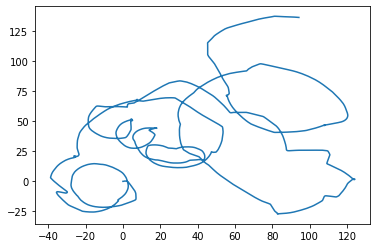

In [39]:
x = [position_data[i][1] for i in range(len(position_data))]
y = [position_data[i][2] for i in range(len(position_data))]

plt.plot(x,y)
